In [1]:
cd ..

/home/mars/src_aiai


In [2]:
from src.util import gpu_setup
gpu_setup()

10 actual GPUs, 1 in use.


In [3]:
import os
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# radio image

In [4]:
from skimage.transform import rescale, resize, downscale_local_mean


In [5]:
from astropy.io import fits

In [6]:
a = fits.getdata("./notebooks/30dor_256.fits")
b = fits.getdata("./notebooks/M31_256.fits")
c = fits.getdata("./notebooks/cluster.fits")

INSTRUME                                                                         [astropy.io.fits.card]


In [7]:
b.min(), c.min()

(-2.215284e-09, -8.490161e-08)

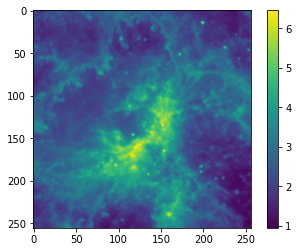

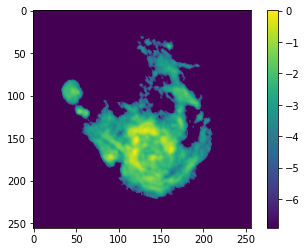

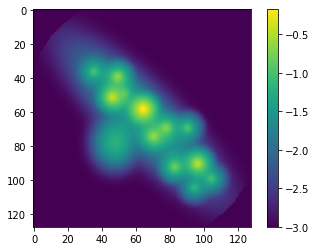

In [8]:
plt.imshow(np.log(a))
plt.colorbar()
plt.show()
plt.imshow(np.log(b[0]+1e-3))
plt.colorbar()
plt.show()
plt.imshow(np.log10(c+1e-3)[0,0])
plt.colorbar()
plt.show()

In [9]:
im1 = np.mean(mpimg.imread('./notebooks/3c353.jpg'), axis=2)
im1 /= im1.max()
log_im1 = np.log(im1 + 1e-9)
# im2 = mpimg.imread('./notebooks/3c353.jpg')

In [10]:
im1.shape

(475, 800)

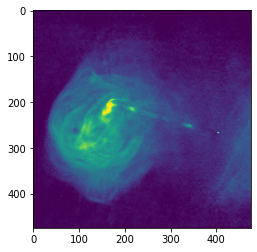

In [11]:
plt.imshow(im1[:475,:475])

In [12]:
im2 = resize(np.pad(im1, ((150, 175), (0,0)), mode="reflect"), (256,256), mode='constant')
im2 /= im2.max()

In [13]:
im2 = resize(im1[:475,:475],  (256,256))
im2 /= im2.max()

In [14]:
im2 = (a-a.min()) / (a.max()-a.min())

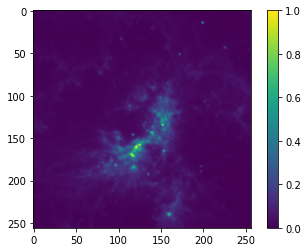

In [15]:
plt.imshow(im2)
plt.colorbar()
plt.show()

# Radio vis

In [16]:
vis = np.loadtxt("./notebooks/vis.txt", delimiter=' ')
uv_radio = vis[np.random.permutation(len(vis)) < 256**2/2][:,:2]
uv_radio *=  np.pi/ np.max(np.abs(uv_radio)) *.999999999
uv_radio = uv_radio[:-1]

In [17]:
data_folder = "./data/intermediate/TNG/NUFFT_Random_var/"
uv_test = np.load(data_folder + "/uv_big.npy")[np.load(data_folder + "/sel.npy")]

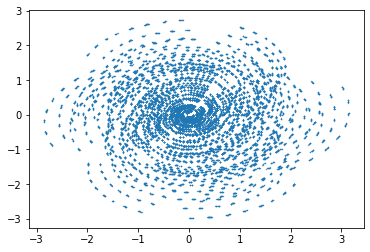

In [18]:
plt.scatter(uv_radio[:,0], uv_radio[:,1], s=.11)

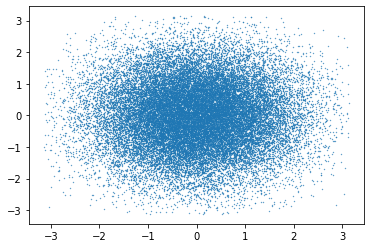

In [19]:
plt.scatter(uv_test[:,0], uv_test[:,1], s=.11)

# Radio operator

In [20]:
from src.operators.NUFFT2D_TF import NUFFT2D_TF


In [21]:
data = "TNG"
operator = "NUFFT_Random_var"

In [22]:
Nd =(256,256)
Kd = (512, 512)
Jd = (6,6)
batch_size = 1

m_op_radio = NUFFT2D_TF()
m_op_radio.plan(uv_radio, Nd, Kd, Jd, batch_size)

m_op_test = NUFFT2D_TF()
m_op_test.plan(uv_test, Nd, Kd, Jd, batch_size)

100%|██████████| 32767/32767 [00:05<00:00, 5511.72it/s]


some values lie out of the interpolation array, these are not used, check baselines


100%|██████████| 32767/32767 [00:05<00:00, 5548.79it/s]


some values lie out of the interpolation array, these are not used, check baselines


In [23]:
# sampling density based weighting
def calc_w(uv):
    grid_cell = 2*np.pi /512 
    binned = (uv[:,:]+np.pi+.5*grid_cell) // grid_cell
    binned = [tuple(x) for x in binned]
    w_gridded = np.zeros(uv.shape[0])

    d = {}
    for i in tqdm.tqdm(binned):
        if i in d:
            d[i] += 1
        else:
            d[i] = 1

    for i in range(len(w_gridded)):
        w_gridded[i] = d[binned[i]]
    # w = 
    w = 1/w_gridded
    w /= w.max()
    return w

w_radio = calc_w(uv_radio)
w_test = calc_w(uv_test)


100%|██████████| 32767/32767 [00:00<00:00, 1737788.73it/s]


# RI net

In [24]:
import tensorflow as tf
from src.networks.UNet_var import UNet_var
from src.networks.GUNet_var import GUNet_var

In [25]:
from skimage.metrics import structural_similarity, peak_signal_noise_ratio, mean_squared_error


In [26]:
operator = "NUFFT_Random_var"
data = "TNG"
ISNR = 30
project_folder = os.environ["HOME"] + "/src_aiai/"
data_folder = project_folder + f"data/intermediate/{data}/{operator}/"

# uv_test = np.load(data_folder + "/uv_original.npy")


In [27]:
y_radio = m_op_radio.dir_op(im2[np.newaxis, :])
y_test = m_op_test.dir_op(im2[np.newaxis, :])




In [28]:
ISNR=30
y_test = m_op_test.dir_op(im2[np.newaxis, :])
data_shape = len(y_test)

sigma = np.sqrt(np.mean(np.abs(y_test)**2)) * 10**(-ISNR/20)
n = np.random.normal( 0, sigma, data_shape) + 1j * np.random.normal( 0, sigma, data_shape)
y_test = y_test + n/np.sqrt(2) # 

## UNet

In [29]:
unet_test = UNet_var(
    Nd, 
    uv=uv_test,
    op=NUFFT2D_TF, 
    depth=4, 
    conv_layers=2,
    input_type="measurements", 
    measurement_weights=np.ones(len(uv_test)),
    batch_size=batch_size,
    residual=True
    )

 11%|█         | 3579/32767 [00:00<00:05, 5578.94it/s]


KeyboardInterrupt: 

In [ ]:
network = "UNet_var"
postfix = "_general_known"
checkpoint_folder = project_folder+ f"models/{data}/{operator}/{network}_{ISNR}dB{postfix}"
latest = tf.train.latest_checkpoint(checkpoint_folder)
unet_test.load_weights(latest)

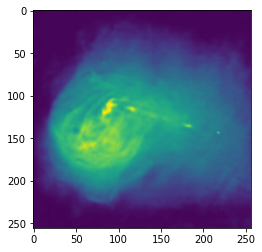

In [69]:
y_pred = unet_test.predict((y_test.numpy(), np.ones_like(y_radio.numpy())))
plt.imshow(y_pred.real[0])

In [ ]:
unet_test.rebuild_with_op(uv_radio[:-1])

In [61]:
y_pred_radio = unet_test.predict((y_radio.numpy()*w_radio[:-1], np.ones_like(y_radio.numpy())))
plt.imshow(y_pred_radio.real[0])

NameError: name 'unet_test' is not defined

## GUNET

In [30]:
gunet = GUNet_var(
    Nd, 
    uv=uv_test,
    op=NUFFT2D_TF, 
    depth=4, 
    conv_layers=2,
    input_type="measurements", 
    measurement_weights=np.ones(len(uv_test)),
    batch_size=batch_size,
    residual=True
    )

100%|██████████| 32767/32767 [00:05<00:00, 5505.24it/s]


some values lie out of the interpolation array, these are not used, check baselines


100%|██████████| 28602/28602 [00:05<00:00, 5596.10it/s]


some values lie out of the interpolation array, these are not used, check baselines


100%|██████████| 19773/19773 [00:03<00:00, 5607.57it/s]


some values lie out of the interpolation array, these are not used, check baselines


100%|██████████| 13810/13810 [00:02<00:00, 5631.40it/s]


some values lie out of the interpolation array, these are not used, check baselines


100%|██████████| 10908/10908 [00:01<00:00, 5611.36it/s]


some values lie out of the interpolation array, these are not used, check baselines
KerasTensor(type_spec=TensorSpec(shape=(None, 32767), dtype=tf.complex64, name='input_1'), name='input_1', description="created by layer 'input_1'") KerasTensor(type_spec=TensorSpec(shape=(1, 256, 256), dtype=tf.float32, name=None), name='tf.__operators__.add/AddV2:0', description="created by layer 'tf.__operators__.add'")


In [31]:
network = "GUNet_var"
postfix = "_general_new"

data = "TNG"

checkpoint_folder = project_folder+ f"models/{data}/{operator}/{network}_{ISNR}dB{postfix}"
latest = tf.train.latest_checkpoint(checkpoint_folder)
gunet.load_weights(latest)

data ="TNG"

y_pred_general = gunet.predict((y_test.numpy(), np.ones_like(y_radio.numpy())))


In [32]:
network = "GUNet_var"
postfix = "_specific_new2"

data = "TNG"

checkpoint_folder = project_folder+ f"models/{data}/{operator}/{network}_{ISNR}dB{postfix}"
latest = tf.train.latest_checkpoint(checkpoint_folder)
gunet.load_weights(latest)

data ="TNG"

y_pred_specific = gunet.predict((y_test.numpy(), np.ones_like(y_radio.numpy())))


In [33]:
network = "GUNet_var"
postfix = "_known_new"

data = "TNG"

checkpoint_folder = project_folder+ f"models/{data}/{operator}/{network}_{ISNR}dB{postfix}"
latest = tf.train.latest_checkpoint(checkpoint_folder)
gunet.load_weights(latest)

data ="TNG"

y_pred_known = gunet.predict((y_test.numpy(), np.ones_like(y_radio.numpy())))

In [34]:
network = "GUNet_var"
postfix = "_specific_known_new"

data = "TNG"

checkpoint_folder = project_folder+ f"models/{data}/{operator}/{network}_{ISNR}dB{postfix}"
latest = tf.train.latest_checkpoint(checkpoint_folder)
gunet.load_weights(latest)

data ="TNG"

y_pred_specific_known = gunet.predict((y_test.numpy(), np.ones_like(y_radio.numpy())))

In [35]:
network = "GUNet_var"
postfix = "_general_known_new"

data = "TNG"

checkpoint_folder = project_folder+ f"models/{data}/{operator}/{network}_{ISNR}dB{postfix}"
latest = tf.train.latest_checkpoint(checkpoint_folder)
gunet.load_weights(latest)

data ="TNG"

y_pred_general_known = gunet.predict((y_test.numpy(), np.ones_like(y_radio.numpy())))

In [36]:
def compare_multiple(images, ncols=None, nrows=None, titles=None, same_scale=False, colorbar=False, cmap='viridis', save_base="./plots/example", cbar_anchor=(1.2, 0), rot=0, vmin=None, vmax=None, ylabel="", log=False):
    """[summary]
    TODO add colorbars
    Args:
        images ([type]): [description]
        ncols ([type], optional): [description]. Defaults to None.
        nrows ([type], optional): [description]. Defaults to None.
        titles ([type], optional): [description]. Defaults to None.
        same_scale (bool, optional): [description]. Defaults to False.
    """

    if not nrows:
        nrows = 1
    if not ncols:
        ncols = 1
    if ncols*nrows < len(images):
        ncols = len(images)
        nrows = 1
    if not titles:
        titles = [""]*len(images)
    
    images = [np.rot90(i, rot) for i in images]
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, 
        figsize=(ncols*6, nrows*6 +1), squeeze=False)

    if log:
        psnr_images = images
        images = np.log10(np.array(images) + 1e-3)
    else:
        psnr_images = images
    
    a = ax[0,0].imshow(images[0])    
    ax[0,0].set_title(titles[0])
    ax[0,0].set_ylabel(ylabel)
    

    
    if vmin is None:
        vmin, vmax = a.get_clim()
    for i in range(0, nrows):
        for j in range(ncols):
            if i +j*nrows >= len(images):
                break
            if same_scale:
                im = ax[i,j].imshow(images[j + i*ncols], 
                    vmin=vmin, vmax=vmax, cmap=cmap)
            else:
                im = ax[i,j].imshow(images[j + i*ncols], cmap=cmap)
            if j % ncols != 0:
                if titles[j + i*ncols]:
                    ax[i,j].set_title(titles[j + i*ncols]  + f"\n(PSNR: {peak_signal_noise_ratio(psnr_images[i*ncols], psnr_images[j + i*ncols], data_range=psnr_images[i*ncols].max()- psnr_images[i*ncols].min()):.2f}dB)" ) 
                else:
                    ax[i,j].set_title(f"(PSNR: {peak_signal_noise_ratio(images[i*ncols], images[j + i*ncols]):.2f}dB)" ) 
                    
            else:
                if titles[j + i*ncols]:
                    ax[i,j].set_title(titles[j + i*ncols] +"\n")
                else:
                    ax[i,j].set_title(titles[j + i*ncols])
                    
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
    if colorbar:
#         plt.colorbar(im, ax=ax, anchor=cbar_anchor, shrink=.8)
        plt.colorbar(im, ax=ax,anchor=cbar_anchor, fraction=0.046, pad=0.04, shrink=.87)
    plt.subplots_adjust(wspace=.01)

In [37]:
x_dirty = m_op_test.adj_op(y_test).numpy().real[0]

In [39]:
res =  a.min() + (a.max()-a.min())*np.array([im2, x_dirty, y_pred_known[0], y_pred_specific[0], y_pred_specific_known[0], y_pred_general[0], y_pred_general_known[0]])

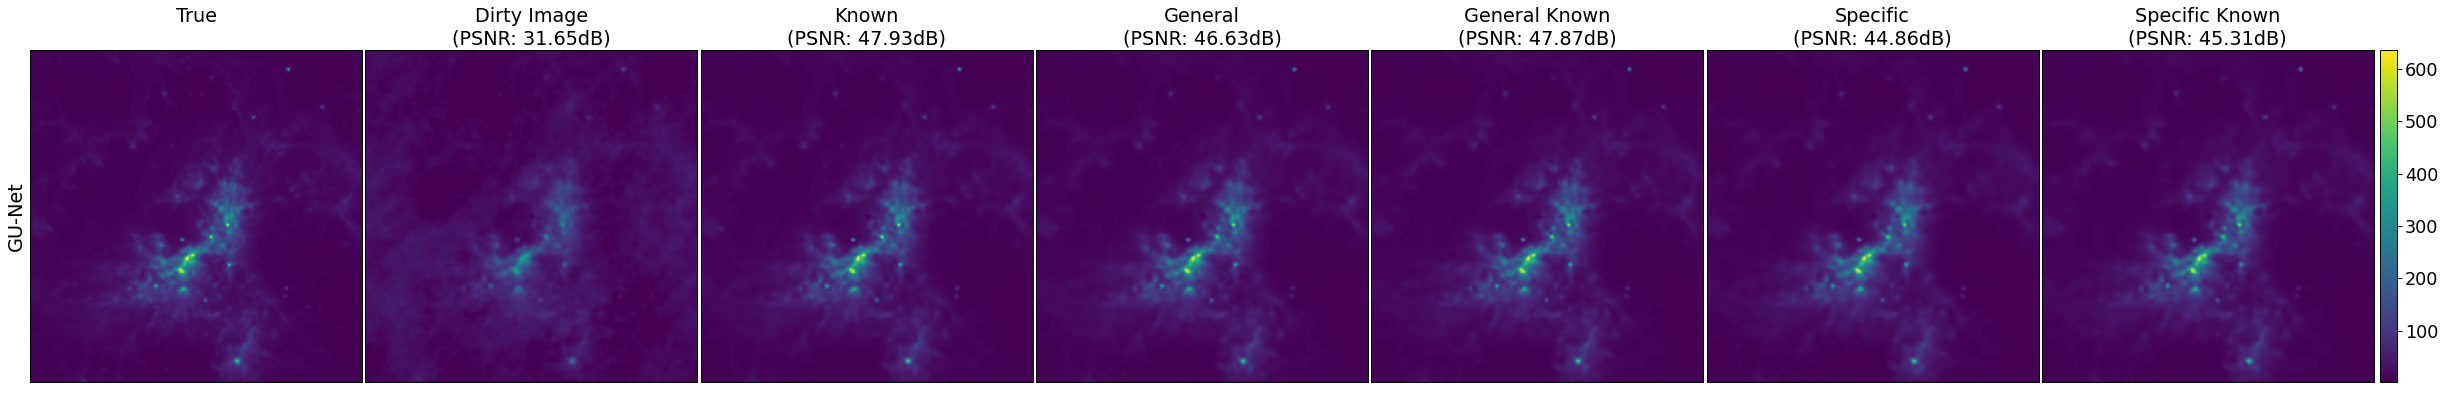

In [42]:
import seaborn as sns
sns.set_context('paper', font_scale=2.0)

compare_multiple(res, titles=["True", "Dirty Image", "Known", "General", "General Known", "Specific", "Specific Known"], same_scale=True, ylabel="GU-Net", cbar_anchor=(1.25,.5), colorbar=True)
plt.savefig("./plots_ri/examples_radio_GUNet_30Dor.pdf")

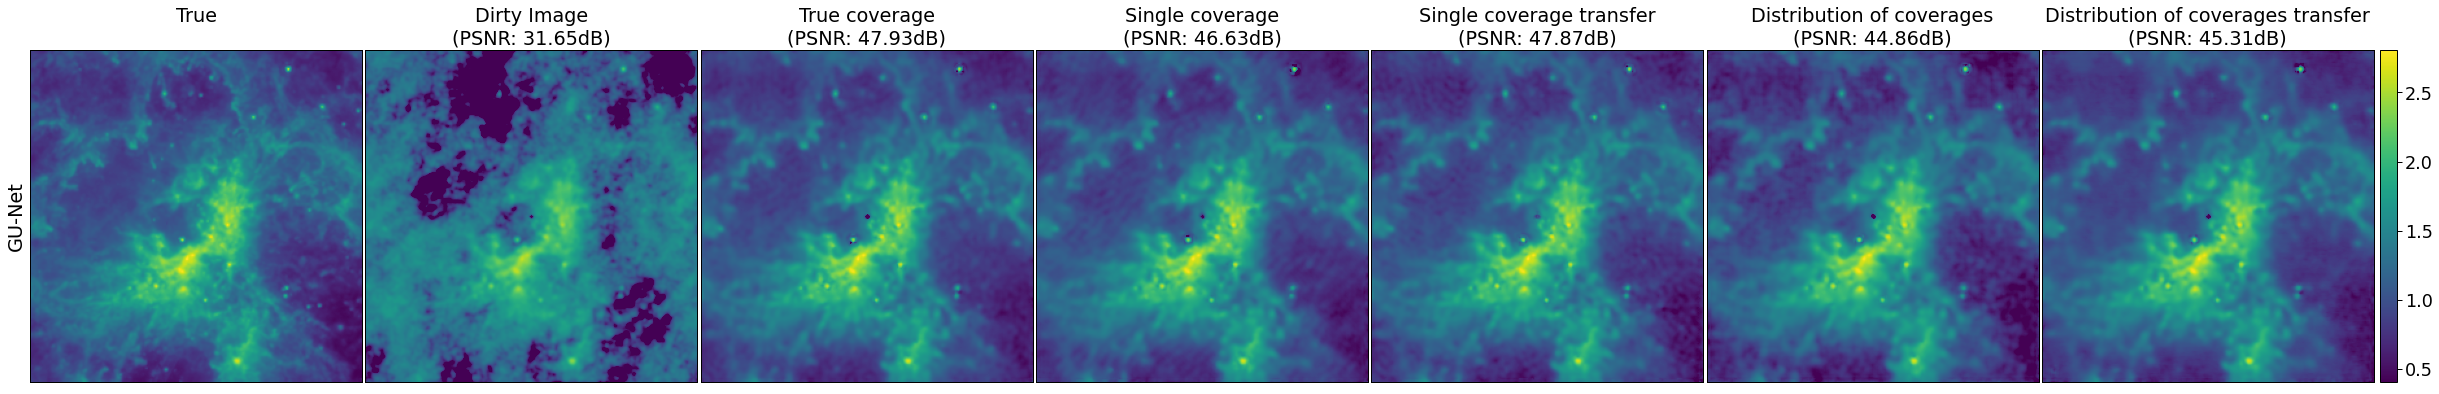

In [43]:
res[res<=0] = 0
compare_multiple(res, titles=["True", "Dirty Image", "True coverage", "Single coverage", "Single coverage transfer", "Distribution of coverages", "Distribution of coverages transfer"], same_scale=True, colorbar=True, log=True, ylabel="GU-Net", cbar_anchor=(1.25,.5))
plt.savefig("./plots_ri/examples_radio_GUNet_log_30Dor.pdf")

(<matplotlib.patches.Rectangle at 0x7fded9ca9f50>,
 (<matplotlib.patches.ConnectionPatch at 0x7fded9b0dd90>,
  <matplotlib.patches.ConnectionPatch at 0x7fded9b0df10>))

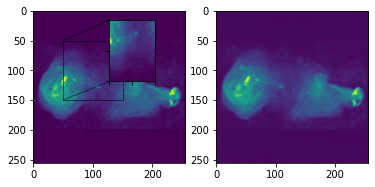

In [92]:
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(im2)
ax[1].imshow(y_pred.real[0])


x1, x2 = 50, 150
y1, y2 = 50, 150
axins = ax[0].inset_axes([0.5, 0.5, 0.3, 0.47])
axins.imshow(im2[x1:x2, y1:y2], extent=[x1,x2, y1,y2], origin="lower")
# sub region of the original image
# x1, x2, y1, y2 = -1.5, -0.9, -2.5, -1.9
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels([])
axins.set_yticklabels([])

ax[0].indicate_inset_zoom(axins, edgecolor="black")

## Radio operator

In [77]:
uv_test.shape, uv_radio.shape

((32767, 2), (32768, 2))

In [118]:
gunet = GUNet_var(
    Nd, 
    uv=uv_radio,
    op=NUFFT2D_TF, 
    depth=4, 
    conv_layers=2,
    input_type="measurements", 
    measurement_weights=np.ones(len(uv_radio)),
    batch_size=batch_size,
    residual=True
    )

100%|██████████| 32767/32767 [00:05<00:00, 6273.88it/s]


some values lie out of the interpolation array, these are not used, check baselines


100%|██████████| 29410/29410 [00:04<00:00, 6612.09it/s]


some values lie out of the interpolation array, these are not used, check baselines


100%|██████████| 21208/21208 [00:03<00:00, 6606.08it/s]


some values lie out of the interpolation array, these are not used, check baselines


100%|██████████| 15468/15468 [00:02<00:00, 6597.30it/s]


some values lie out of the interpolation array, these are not used, check baselines


100%|██████████| 11856/11856 [00:01<00:00, 6601.35it/s]


some values lie out of the interpolation array, these are not used, check baselines
KerasTensor(type_spec=TensorSpec(shape=(None, 32767), dtype=tf.complex64, name='input_9'), name='input_9', description="created by layer 'input_9'") KerasTensor(type_spec=TensorSpec(shape=(1, 256, 256), dtype=tf.float32, name=None), name='tf.__operators__.add_2/AddV2:0', description="created by layer 'tf.__operators__.add_2'")


In [129]:
network = "GUNet_var"
postfix = "_specific_new2"

data = "TNG"

checkpoint_folder = project_folder+ f"models/{data}/{operator}/{network}_{ISNR}dB{postfix}"
latest = tf.train.latest_checkpoint(checkpoint_folder)
gunet.load_weights(latest)

data ="TNG"

In [130]:
y_pred_general = gunet.predict((y_radio.numpy(), np.ones_like(y_radio.numpy())))


In [137]:
x_dirty_radio = m_op_radio.adj_op(y_radio).numpy().real[0]

/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.


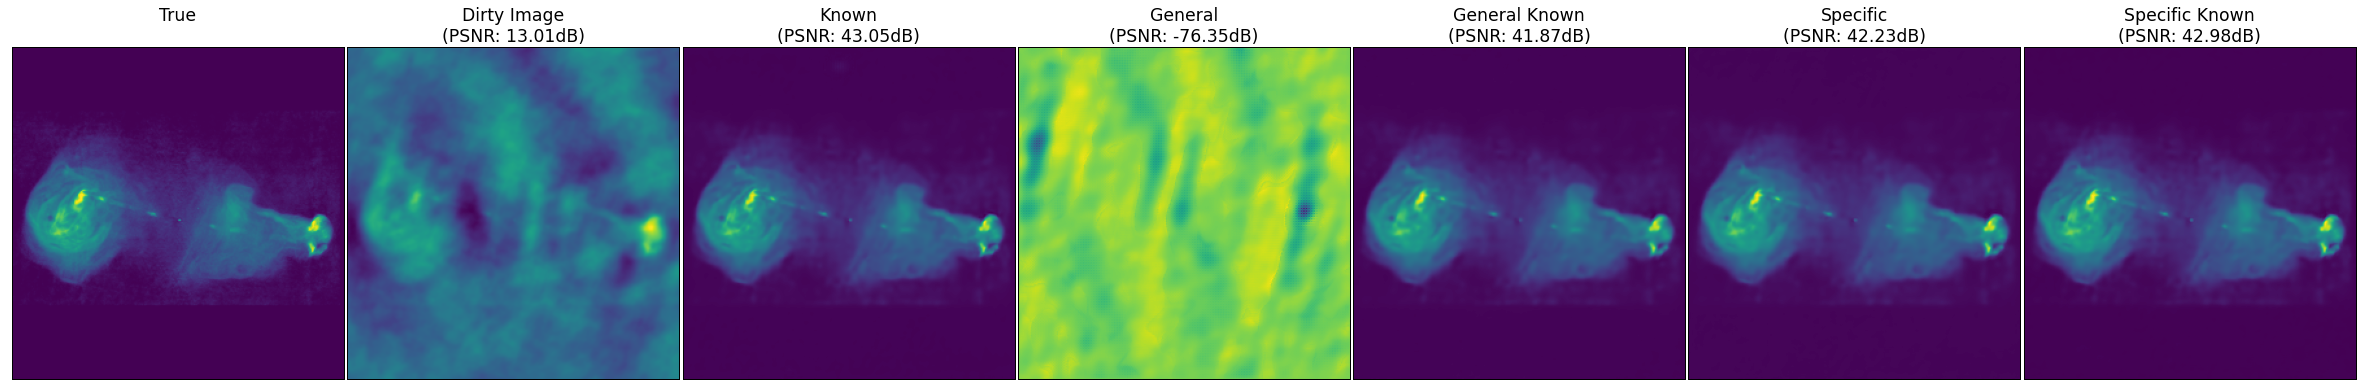

In [138]:
import seaborn as sns
sns.set_context('paper', font_scale=1.8)

compare_multiple([im2, x_dirty_radio, y_pred_known[0], y_pred_general[0], y_pred_general_known[0], y_pred_specific[0], y_pred_specific_known[0]], titles=["True", "Dirty Image", "Known", "General", "General Known", "Specific", "Specific Known"])

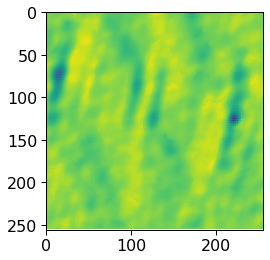

In [132]:
plt.imshow(y_pred_general.real[0])